## Reference  
model: https://pytorch.org/tutorials/beginner/chatbot_tutorial.html#define-training-procedure  
dataset: https://github.com/zake7749/Gossiping-Chinese-Corpus/tree/master

目標: 以 flask 實現網頁 APP，並利用 pytorch 訓練語到對語言架構，把使用者輸入丟進 pre-train model 進行回應。  
相關資訊請參考: https://github.com/efef31016/Useful_Practice/tree/main/AIBOT

In [ ]:
!gdown --id '1r4px0i-NcrnXy1-tkBsIwvYwbWnxAhcg' --output data.tar.gz
!tar -zxvf data.tar.gz
!mkdir ckpt
!ls

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1r4px0i-NcrnXy1-tkBsIwvYwbWnxAhcg
To: /content/data.tar.gz
100% 5.83M/5.83M [00:00<00:00, 165MB/s]
cmn-eng/
cmn-eng/int2word_cn.json
cmn-eng/int2word_en.json
cmn-eng/preprocess/
cmn-eng/preprocess/build_dataset.py
cmn-eng/preprocess/build_dictionary.sh
cmn-eng/preprocess/cmn.txt
cmn-eng/preprocess/cn.txt
cmn-eng/preprocess/dict.txt.big
cmn-eng/preprocess/dict.txt.small
cmn-eng/preprocess/en.txt
cmn-eng/preprocess/en_code.txt
cmn-eng/preprocess/en_refine.txt
cmn-eng/preprocess/en_vocab.txt
cmn-eng/preprocess/tokenizer.py
cmn-eng/testing.txt
cmn-eng/training.txt
cmn-eng/validation.txt
cmn-eng/word2int_cn.json
cmn-eng/word2int_en.json
mkdir: cannot create directory ‘ckpt’: File exists
ckpt  cmn-eng  data.tar.gz  drive  sample

In [ ]:
%%capture
!pip3 install --user nltk

In [ ]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json

import matplotlib.pyplot as plt
import numpy as np

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
def transform(txtlist, word2int, index):

  BOS = 0
  EOS = 1
  UNK = 2

  cn = [BOS]

  for word in txtlist[index]:
    cn.append(word2int.get(word, UNK))  # 若 word 不存在就用 UNK 取代
  cn.append(EOS)

  cn = np.asarray(cn)
  cn = torch.LongTensor(cn)

  return cn

word2int: key-word, value-times  
int2word: key-int, value-time the word appear  
(not so good)

In [ ]:
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

In [ ]:
root = "/content/"
dat = "/content/drive/MyDrive/Gossiping-QA-Dataset.txt"

# def punc(sentence):
#   l=[]
#   for char in range(len(sentence)):
#     if sentence[char] in ["。", "，", "；", "：", "！", "？", "（", "）", "【", "】", "“", "”", "——", "…", "／"]:
#       l.append(char)
#   num=0
#   for i in l:
#     sentence = sentence[:i+num] + " " + sentence[i+num] + " " + sentence[i+num+1:]
#     num+=2
#   return sentence

PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

# 建立詞彙表 & 資料、label切分
allData = []
int2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
word2int = {}
PAD_token = 0
SOS_token = 1
EOS_token = 2
vocdict_num = 3

with open(dat, "r") as file:
  for line in file:
    combine = list(filter(None, line.replace(" ", "").split('\t')))
    try:
      for i in range(2):
        for token in combine[i]:
          # 小技巧: 唯一性
          if token not in word2int:
            word2int[token] = vocdict_num
            int2word[vocdict_num] = token
            vocdict_num += 1
          else:
            word2int[token] += 1
      allData.append(combine)
    except:
      print("unuseful!")

  print("data size:", len(allData))

排除太多沒看過的字 (if necessary)

In [ ]:
# Mintimes = 5
# for i in trainData:
#   for j in i:
#     if word2int[j] < 5:
#       traintrim = trainData.pop(i)
#       labeltrim = labelData.pop(i)

取得隨機 mini-batch 的資料並吐出  
input_variable  
lengths  
target_variable  
mask

In [ ]:
class Batchdata:
  def __init__(self, word2int, trainData, batch_size = 1, n_iteration = 1, labelData = False, method = "no_onehot"):
    self.word2int = word2int
    self.trainData = trainData
    self.batch_size = batch_size
    self.n_iteration = n_iteration
    if not labelData:
      self.labelData = labelData
    else:
      self.labelData = labelData

    self.method = method

  def rd(self,):
    numbers_list = list(range(len(self.trainData)))
    rds = random.sample(numbers_list, self.batch_size)
    return rds


  def padding(self, x, padlen, train=True):

    mask = []

    for k in range(len(x)):

      mk = []
      if not train:
        for i in range(padlen):
          if i < len(x[k]):
            mk.append(True)
          else:
            mk.append(False)

      mask.append(mk)

      x[k] = np.pad(x[k],
      (0, (padlen - len(x[k]))), mode='constant', constant_values = 0)

    return x, mask

  def Getdata(self,):

    batchTrain = []

    for i in range(self.n_iteration):

      trainBatchi = []
      labelBatchi = []
      rdidx = self.rd()

      if self.method == "no_onehot":
        trainBatchi.append([transform(self.trainData, word2int, j) for j in rdidx])
      else:
        trainBatchi.append([self.trainData[j] for j in rdidx])

      if not self.labelData:
        print("evaluate")
      else:
        if self.method == "no_onehot":
          labelBatchi.append([transform(labelData, word2int, j) for j in rdidx])
        else:
          labelBatchi.append([self.labelData[j] for j in rdidx])

        # print(rdidx)
        # print(labelBatchi)

        labelBatchi = sorted(labelBatchi[0], key=lambda x: x.shape[0], reverse=True)
        labelPadlen = max(labelBatchi, key=len).shape[0]
        labelBatchi = self.padding(labelBatchi, labelPadlen, False)
        mask = np.asarray(labelBatchi[1])
        mask = torch.LongTensor(mask)
        mask = mask.bool()
        mask = torch.BoolTensor(mask)
        mask = torch.transpose(mask, 0, 1)
        labelBatchi = np.asarray(labelBatchi[0])
        labelBatchi = torch.LongTensor(labelBatchi)
        labelBatchi = torch.transpose(labelBatchi, 0, 1)


      trainBatchi = sorted(trainBatchi[0], key=lambda x: x.shape[0], reverse=True)
      length = torch.tensor([len(tensor) for tensor in trainBatchi]).view(-1)
      trainPadlen = max(trainBatchi, key=len).shape[0]
      trainBatchi = self.padding(trainBatchi, trainPadlen)
      trainBatchi = np.asarray(trainBatchi[0])
      trainBatchi = torch.LongTensor(trainBatchi)
      trainBatchi = torch.transpose(trainBatchi, 0, 1)

      try:
        batchTrain.append([trainBatchi, length, labelBatchi, mask, mask.shape[0]])
      except:
        batchTrain.append([trainBatchi, length])

    return batchTrain

In [ ]:
with open(dat, "r") as file:
  for line in file:
    combine = list(filter(None, line.replace(" ", "").split('\t')))
    try:
      for i in range(2):
        for token in combine[i]:
          # 小技巧: 唯一性
          if token not in word2int:
            word2int[token] = vocdict_num
            int2word[vocdict_num] = token
            vocdict_num += 1
          else:
            word2int[token] += 1
      allData.append(combine)
    except:
      print("unuseful!")

  print("data size:", len(allData))
allData[:20]
trainData = []
labelData = []
for qa in allData:
  trainData.append([token for token in qa[0]])
  labelData.append([token for token in qa[1]])
trainData[:3], labelData[:3]

unuseful!
unuseful!
unuseful!
data size: 563290


([['為',
   '什',
   '麼',
   '聖',
   '結',
   '石',
   '會',
   '被',
   '酸',
   '而',
   '這',
   '群',
   '人',
   '不',
   '會',
   '？'],
  ['為',
   '什',
   '麼',
   '慶',
   '祝',
   '2',
   '2',
   '8',
   '會',
   '被',
   '罵',
   '可',
   '是',
   '慶',
   '端',
   '午',
   '不',
   '會',
   '？'],
  ['有', '沒', '有', '戰', '神', '阿', '瑞', '斯', '的', '八', '卦', '?']],
 [['質',
   '感',
   '劇',
   '本',
   '成',
   '員',
   '都',
   '差',
   '很',
   '多',
   '好',
   '嗎',
   '不',
   '要',
   '拿',
   '腎',
   '結',
   '石',
   '來',
   '污',
   '辱',
   '這',
   '群',
   '人',
   '\n'],
  ['因',
   '為',
   '屈',
   '原',
   '不',
   '是',
   '台',
   '灣',
   '人',
   '，',
   '是',
   '楚',
   '國',
   '人',
   '。',
   '\n'],
  ['爵',
   '士',
   '就',
   '是',
   '阿',
   '瑞',
   '斯',
   '男',
   '主',
   '角',
   '最',
   '後',
   '死',
   '了',
   '\n']])

In [ ]:
batch_size = 64
n_iteration = 4000

batchData = Batchdata(word2int, trainData, batch_size, n_iteration, labelData).Getdata()
batchData[0][0].shape, batchData[0][1].shape, batchData[0][2].shape, batchData[0][3].shape, batchData[0][4]

(torch.Size([25, 64]),
 torch.Size([64]),
 torch.Size([27, 64]),
 torch.Size([27, 64]),
 27)

word2int: ont-hot encoding  
int2word: same as above  
(meaningful)

In [ ]:
dat = "/content/drive/MyDrive/Gossiping-QA-Dataset.txt"

PAD_token = 0
SOS_token = 1
EOS_token = 2

voclist={"PAD_token": 0}  # 查找速度較快

with open(dat, "r") as file:
  for line in file:
    for j in line:
      if j not in voclist:
        voclist[j] = 0

In [ ]:
voc_list = []
for i, j in voclist.items():
  voc_list.append(i)

In [ ]:
class GetTrainLable:
  def __init__(self, allData, voc_list):
    self.allData = allData
    self.voc_list = voc_list

  def to_binary(self, num, l):
    if num == 0:
      return l
    quo = num // 2
    rem = num % 2
    l.append(rem)
    return self.to_binary(quo, l)

  def ohencoding(self,):

    wordint = {}
    maxlen = int(np.log2(len(self.voc_list))) + 1

    for i, j in enumerate(self.voc_list):
      l = self.to_binary(i, [])
      comp = [0 for _ in range(maxlen - len(l))]
      wordint[j] = np.asarray(l + comp + [1])
      wordint[j] = torch.LongTensor(wordint[j])

    self.voc_dict = wordint


  def Getdata(self,):

    self.ohencoding()

    trainData = []
    labelData = []
    for qa in self.allData:
      trainData.append(torch.cat([self.voc_dict[token] for token in qa[0]], dim=0))
      labelData.append(torch.cat([self.voc_dict[token] for token in qa[1]], dim=0))
    return trainData, labelData

In [ ]:
TrainLabel = GetTrainLable(allData, voc_list)
trainData, labelData = TrainLabel.Getdata()
voc_dict = TrainLabel.voc_dict

In [ ]:
voc_dict

{'PAD_token': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '為': tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '什': tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '麼': tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 ' ': tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '聖': tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '結': tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '石': tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '會': tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '被': tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '酸': tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '而': tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '這': tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '群': tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '人': tensor([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '不': tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '？': tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 '\t':

In [ ]:
trainData[100].shape, labelData[100].shape

(torch.Size([56]), torch.Size([238]))

把字數太多的拿掉

182.35126133962967
644


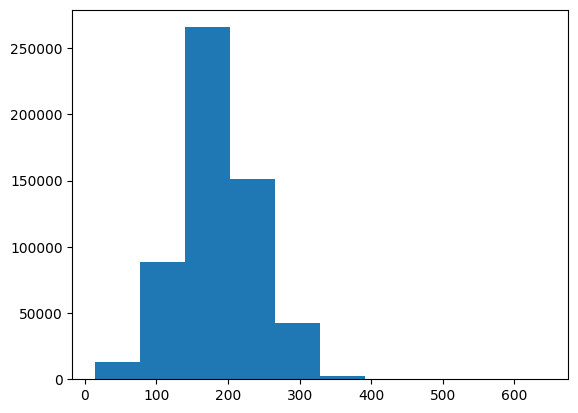

In [ ]:
mm = 0
mean = 0
dist = []
for i,j in enumerate(trainData):
  dist.append(len(j))
  mean += len(j)
  if len(j) > mm:
    mm = len(j)
print(mean/len(trainData))
print(mm)
plt.hist(dist)
plt.show()

In [ ]:
MAX_legth = 400
for i, j in enumerate(trainData):
  if len(j)>400:
    trainData.pop(i)
    labelData.pop(i)

In [ ]:
batch_size = 16
n_iteration = 10000

batchTrain = Batchdata("pass", trainData, batch_size, n_iteration, labelData, method = "onehot").Getdata()
batchData[0][0].shape, batchData[0][1].shape, batchData[0][2].shape, batchData[0][3].shape, batchData[0][4]

(torch.Size([25, 64]),
 torch.Size([64]),
 torch.Size([27, 64]),
 torch.Size([27, 64]),
 27)

模型

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [ ]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [ ]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [ ]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [ ]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for RNN packing should always be on the CPU
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [ ]:
def trainIters(model_name, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename, batchTrain, voc_dict):

    # Load batches for each iteration
    training_batches = [batchTrain[i] for i in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    # if loadFilename:
    #     start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'embedding': embedding.state_dict(),
                'voc_dict' : voc_dict
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

初始化超參數並訓練模型

In [ ]:
# Configure models
corpus_name = "Gossiping-QA-Dataset"
model_name = 'chatbot'
attn_model = 'dot'
#``attn_model = 'general'``
#``attn_model = 'concat'``
hidden_size = 50
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
# batch_size = 16

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000

save_dir = "/content/drive/MyDrive"


In [ ]:
print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(len(voc_dict), hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, len(voc_dict), decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [ ]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
# n_iteration = 10000
print_every = 1
save_every = 100

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

# If you have CUDA, configure CUDA to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename, batchTrain, voc_dict)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.0%; Average loss: 8.9172
Iteration: 2; Percent complete: 0.0%; Average loss: 8.8501
Iteration: 3; Percent complete: 0.0%; Average loss: 8.7852
Iteration: 4; Percent complete: 0.0%; Average loss: 8.7198
Iteration: 5; Percent complete: 0.1%; Average loss: 8.6547
Iteration: 6; Percent complete: 0.1%; Average loss: 8.5886
Iteration: 7; Percent complete: 0.1%; Average loss: 8.5114
Iteration: 8; Percent complete: 0.1%; Average loss: 8.4558
Iteration: 9; Percent complete: 0.1%; Average loss: 8.3746
Iteration: 10; Percent complete: 0.1%; Average loss: 8.3139
Iteration: 11; Percent complete: 0.1%; Average loss: 8.2275
Iteration: 12; Percent complete: 0.1%; Average loss: 8.1407
Iteration: 13; Percent complete: 0.1%; Average loss: 8.0467
Iteration: 14; Percent complete: 0.1%; Average loss: 7.9499
Iteration: 15; Percent complete: 0.1%; Average loss: 7.8375
Iteration: 16; Percent complete: 0.2%

KeyboardInterrupt: ignored

In [ ]:
class GreedySearchDecoder(nn.Module):
  def __init__(self, encoder, decoder):
      super(GreedySearchDecoder, self).__init__()
      self.encoder = encoder
      self.decoder = decoder

  def forward(self, input_seq, input_length, max_length):
      # Forward input through encoder model
      encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
      # Prepare encoder's final hidden layer to be first hidden input to the decoder
      decoder_hidden = encoder_hidden[:decoder.n_layers]
      # Initialize decoder input with SOS_token
      decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
      # Initialize tensors to append decoded words to
      all_tokens = torch.zeros([0], device=device, dtype=torch.long)
      all_scores = torch.zeros([0], device=device)
      # Iteratively decode one word token at a time
      for _ in range(max_length):
          # Forward pass through decoder
          decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
          # Obtain most likely word token and its softmax score
          decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
          # Record token and score
          all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
          all_scores = torch.cat((all_scores, decoder_scores), dim=0)
          # Prepare current token to be next decoder input (add a dimension)
          decoder_input = torch.unsqueeze(decoder_input, 0)
      # Return collections of word tokens and scores
      return all_tokens, all_scores

In [ ]:
def getInput(userInput, voc_dict):

  lenchar = len(next(iter(voc_dict.values())))
  trainData = []
  trainData.append([voc_dict.get(token, [0.5 for _ in range(lenchar)]) for token in userInput])
  trainData = torch.cat(trainData[0], dim=0)
  return Batchdata("pass", [trainData], method="onehot").Getdata()

def converse(idxint, voc_dict):
  word = next((key for key, value in voc_dict.items() if torch.equal(value, idxint)), " ")
  return word

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [ ]:
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

EncoderRNN：這是一個用於處理輸入句子的編碼器（Encoder）。它使用嵌入層（embedding layer）將輸入單詞轉換為嵌入向量，並通過多層的雙向 GRU 循環神經網絡進行編碼。

LuongAttnDecoderRNN：這是一個帶有 Luong 注意力機制的解碼器（Decoder）。它使用嵌入層（embedding layer）將輸入單詞轉換為嵌入向量，並通過多層的 GRU 循環神經網絡進行解碼。在解碼的過程中，它使用注意力機制來對編碼器的輸出進行加權，以獲取更好的上下文信息。

In [ ]:
searcher.encoder, searcher.decoder

(EncoderRNN(
   (embedding): Embedding(6932, 50)
   (gru): GRU(50, 50, num_layers=2, dropout=0.1, bidirectional=True)
 ),
 LuongAttnDecoderRNN(
   (embedding): Embedding(6932, 50)
   (embedding_dropout): Dropout(p=0.1, inplace=False)
   (gru): GRU(50, 50, num_layers=2, dropout=0.1)
   (concat): Linear(in_features=100, out_features=50, bias=True)
   (out): Linear(in_features=50, out_features=6932, bias=True)
   (attn): Attn()
 ))

In [ ]:
res = AiBot(input("> "), encoder, decoder, voc_dict)
print(res)

> 公三小
evaluate
不石石石石石石石石石石石石石








# 底下為導入APP中的程式碼

In [ ]:
def AiBot(strinput, encoder, decoder, voc_dict):

  # Set dropout layers to ``eval`` mode
  encoder.eval()
  decoder.eval()

  # Initialize search module
  searcher = GreedySearchDecoder(encoder, decoder)

  input_var, lengths = getInput(strinput, voc_dict)[0]

  wordnum = len(next(iter(voc_dict.values())))
  MAXLENGTH = 20 * wordnum
  result = searcher.forward(input_var, lengths, MAXLENGTH)
  word_res = [result[0][i:i+wordnum] for i in range(0, MAXLENGTH, wordnum)]
  res = ""
  for i in word_res:
    res += converse(i, voc_dict)

  return res

In [ ]:
# Configure models
corpus_name = "Gossiping-QA-Dataset"
model_name = 'chatbot'
attn_model = 'dot'
hidden_size = 50
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 16

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 2000

save_dir = "/content/drive/MyDrive"

In [ ]:
loadFilename = os.path.join(save_dir, model_name, corpus_name,
                    '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                    '{}_checkpoint.tar'.format(checkpoint_iter))

if loadFilename:
  # If loading on same machine the model was trained on
  checkpoint = torch.load(loadFilename)
  # If loading a model trained on GPU to CPU
  #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
  encoder_sd = checkpoint['en']
  decoder_sd = checkpoint['de']
  encoder_optimizer_sd = checkpoint['en_opt']
  decoder_optimizer_sd = checkpoint['de_opt']
  embedding_sd = checkpoint['embedding']
  voc_dict = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(len(voc_dict), hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)

# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, len(voc_dict), decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [ ]:
res = AiBot(input("> "), encoder, decoder, voc_dict)
# 把 res 輸出到 APP

> 垃圾
evaluate


In [ ]:
print(res)

不麼麼麼麼麼麼麼麼麼麼









